<a href="https://colab.research.google.com/github/kashyap333/Tabular-Playground-Series---Aug-2022/blob/main/Pytorch__Tabular_Playground_Series_Aug_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Kaggle requirements 

1) Data download and unzipping

In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c tabular-playground-series-aug-2022

In [ ]:
!unzip tabular-playground-series-aug-2022

## Installing requirements

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer, KNNImputer
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import StandardScaler 
import torch
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import DataLoader, Dataset, TensorDataset

In [63]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train_test = pd.concat([train[test.columns], test], ignore_index=True)

## Preprocessing of Data

1) KNNImputer for NA values

2) Standard scaler of columns

3) Smote as Target labels are unbalanced

In [54]:
object_columns = ['product_code', 'attribute_0', 'attribute_1']
train_test.drop(['id'], axis=1, inplace=True)
#train_test_object = train_test.copy()
train_test.drop(object_columns, axis=1, inplace=True)
all_columns = train_test.columns

In [72]:
train.failure.value_counts()

0    20921
1     5649
Name: failure, dtype: int64

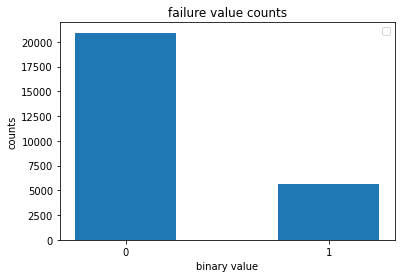

In [80]:
plt.bar(x=train.failure.unique(), height=train.failure.value_counts(), tick_label=train.failure.unique(), width =0.5)
plt.title('failure value counts')
plt.ylabel('counts')
plt.xlabel('binary value')

plt.legend()
#plt.label()

In [5]:
imp = KNNImputer(n_neighbors=3)
std_scaler = StandardScaler()
for i in train_test.columns:
  
  train_test[[i]] = imp.fit_transform(train_test[[i]])

train_test[all_columns] = std_scaler.fit_transform(train_test[all_columns])

In [6]:
full_data = train_test.copy()

In [20]:
x_train = full_data.iloc[:train.shape[0], :]
y_train = train.failure.astype('float')
x_test = full_data.iloc[train.shape[0]:, :]

In [21]:
sm = SMOTE(random_state=42)
x_train, y_train = sm.fit_resample(x_train, y_train)
print('Resampled dataset shape %s' % Counter(y_train))

Resampled dataset shape Counter({0.0: 20921, 1.0: 20921})


In [103]:
x_train.shape, y_train.shape

((41842, 21), (41842,))

# Loading dataset into pytorch, i.e: Pytorch tensors

Device agnostic code

In [9]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))

Dataset class to make pytorch dataset for train and test

In [22]:
class aug_train(Dataset):
  def __init__(self, x_train, y_train):
    
    self.X_train = torch.from_numpy(x_train.values.astype(np.float32))
    self.y_train = torch.from_numpy(y_train.values.astype(np.float32))

  def __len__(self):
    return len(self.y_train)

  def __getitem__(self, idx):
    return self.X_train[idx], self.y_train[idx]

In [23]:
class aug_test(Dataset):
  def __init__(self, x_test):
    
    self.X_test = torch.from_numpy(x_test.values.astype(np.float32))
  

  def __len__(self):
    return len(self.X_test)

  def __getitem__(self, idx):
    return self.X_test[idx]

In [24]:
train_data = aug_train(x_train, y_train)
test_data = aug_test(x_test)

Dataloaders for dataset

In [25]:
train_dataloader = DataLoader(train_data, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=16)

Sanity check to data and batches

In [ ]:
dataiter = iter(train_dataloader)
dataiter
data, labels = dataiter.next()
data, labels

Building Model

In [26]:
class LinearModel(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer1 = nn.Linear(in_features=21, out_features=32)
    self.layer2 = nn.Linear(in_features=32, out_features=16)
    self.layer3 = nn.Linear(in_features=16, out_features=8)
    self.layer4 = nn.Linear(in_features=8, out_features=1)

    self.relu = nn.ReLU()
    self.batch_norm1 = nn.BatchNorm1d(63)
    self.batch_norm2 = nn.BatchNorm1d(31)
    self.dropout = nn.Dropout(p=0.1)


  def forward(self, x: torch.tensor):
      x = self.layer1(x)
      #x = self.batch_norm1(x)
      x = self.layer2(x)
      x = self.layer3(x)
      #x = self.batch_norm2(x)
      #x = self.dropout(x)
      x = self.layer4(x)

      return x

torch.manual_seed(42)
model = LinearModel()
#model, model.state_dict()

Transferring model to gpu

In [27]:
model.to(device)
next(model.parameters()).device

device(type='cuda', index=0)

Loss and optmiter for NN

In [28]:
loss_fn = nn.L1Loss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

Training loop

In [ ]:
torch.manual_seed(42)

loss_value = []
epoch_no = []
epochs = 500



for epoch in range(epochs+1):
  model.train()
  for x_train, y_train in train_dataloader:
    
    x_train = x_train.to(device)
    y_train = y_train.to(device)

    y_pred = model(x_train)

    loss = loss_fn(y_pred, y_train.unsqueeze(1))

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()



  if epoch % 50 == 0:
    print(f'Epoch: {epoch} | Loss: {loss}')
    loss_value.append(loss.detach().cpu().numpy())
    epoch_no.append(epoch)



Plotting of trainloss 


In [ ]:
plt.plot(epoch_no, loss_value, label="Train loss")
#plt.plot(epoch_no, loss_value, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

Making Inference and submission to kaggle

In [ ]:
test_loss = []

model.eval()
for x_test in test_dataloader:
  x_test = x_test.to(device)
  with torch.inference_mode():
    test_pred = model(x_test)
    test_pred_value = test_pred.cpu().numpy()
    

    test_loss.append(test_pred_value)

In [ ]:
final_probs = [item for sublist in test_loss for item in sublist]


In [44]:
result = []
for i in range(len(final_probs)):
  result.append(final_probs[i][0])


In [46]:
len(result), len(test)

(20775, 20775)

In [47]:
results = pd.DataFrame(test.id)
results['failure'] = result
result = results.to_csv('result.csv', index=False)

In [48]:
results.head()

,id,failure
0,26570,0.558313
1,26571,0.301167
2,26572,0.415456
3,26573,0.367955
4,26574,1.026577


In [49]:
!kaggle competitions submit -c tabular-playground-series-aug-2022 -f result.csv -m "Pytorch"

100% 338k/338k [00:00<00:00, 967kB/s]
Successfully submitted to Tabular Playground Series - Aug 2022